In [0]:
!pip install neurodsp

In [0]:
import numpy as np
import pandas as pd
import neurodsp

Разполагаме с два файла в csv формат с данни от Motor imagery _(MI)_ тестове - [fail1](https://www.link-kum.github1) и [fail2](https://www.link-kum.github2).

  **Използвано устройство: [EMOTIV EPOC+ 14ch mobile eeg](https://www.emotiv.com/product/emotiv-epoc-14-channel-mobile-eeg/#tab-description)**
  
  _да се уточни, защото е важно за_ ->

   <img src="https://www.researchgate.net/profile/Raja_Majid_Mehmood/publication/309427804/figure/fig2/AS:421358589759489@1477471124092/Emotiv-EPOC-headset-14-channel-placement-with-two-reference-channels.png" width="256px" height="256px">

In [0]:
file_url1 = 'https://github.com/YYx00xZZ/UniBIT-Study/blob/colab/data/input/1_GD_Standart_14ch_24.01.2020.csv?raw=true'
file_url2 = 'https://github.com/YYx00xZZ/UniBIT-Study/blob/master/data/input/2_GD_Standart_14ch_24.01.2020.csv?raw=true'
initial_col_names = ['Time128Hz', 'Epoch', 'AF3', 'F7', 'F3', 'F5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4', 'EventId', 'EventDate', 'EventDuration']

In [0]:
df1 = pd.read_csv(file_url1, names=initial_col_names, index_col=False, header=None, sep=',',skiprows=1, dtype={'EventId' : str})
df2 = pd.read_csv(file_url2, names=initial_col_names, index_col=False, header=None, sep=',',skiprows=1, dtype={'EventId' : str})

In [0]:
df1.fillna(0, inplace=True) # за всички NaN полета задаваме стойност 0b

### Колона EventId ни е нужна, но съдържа празни полета..
#### Програмно преизползваемо решение:
<details>
  <summary>Което логически дефинираме така:</summary>
  
  * <details>
      <summary>def filter_ids(data): #L1</summary>

      ```
      Read from CSV | достъпваме стойност на клетка 1
      Get EventId as EventID_NEW | запзваме стойността в променлива *
      Next Row итерация (следващ ред) 3
      If EventId = null ако клетката е празна 4
          Update Row set EventId = EventID_NEW приравняваме с променлива от *
      Else в противен случей (случай!?)
          EventID_NEW = EventId презаписваме стойността от * с новата срещната
      Loop to Next Row | следващ ред
      WRITE NEW CSV
      ```
    </details>

In [0]:
# alg. 1
def filter_ids(data):
    currentId = ''
    idToSet = ''
    for index, row in data.iterrows():
        currentId = str(row['EventId'])
        if currentId == '0':
            data.at[index, 'EventId'] = str(idToSet)
        else:
            currentId = str(row['EventId'])
            idToSet = str(row['EventId'])
    return data

In [8]:
df1 = filter_ids(df1)
df1.head()

,Time128Hz,Epoch,AF3,F7,F3,F5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4,EventId,EventDate,EventDuration
0,0.000000,0,4094.358887,4104.615234,4076.666748,4061.923096,4047.948730,4062.435791,4122.948730,4061.025635,4064.102539,4075.256348,4050.641113,4063.333252,4111.666504,4070.512939,32769,0.0072936108,0.0000000000
1,0.007812,0,4094.358887,4106.282227,4074.615479,4065.512939,4052.692383,4068.589844,4133.589844,4072.564209,4078.718018,4091.538574,4063.718018,4068.461426,4116.025879,4078.461426,32769,0,0
2,0.015625,0,4098.974121,4108.974121,4078.718018,4065.897461,4058.333252,4076.410156,4139.358887,4077.820557,4084.102539,4096.538574,4075.897461,4079.102539,4116.025879,4086.025635,32769,0,0
3,0.023438,0,4093.846191,4108.205078,4080.384521,4063.974365,4052.820557,4076.025635,4137.307617,4077.435791,4085.256348,4095.000000,4076.538574,4094.230713,4119.615234,4091.410156,32769,0,0
4,0.031250,0,4094.743652,4105.769043,4080.512939,4063.076904,4050.641113,4074.102539,4140.256348,4085.512939,4090.384521,4105.384766,4081.538574,4090.256348,4125.641113,4094.487061,32769,0,0


### Проверяваме уникалните стойности в колоната _EventId_

In [9]:
df1['EventId'].unique()

array(['32769', '32775', '32776', '33282:768', '786', '32780', '33025',
       '32777', '32780:32778:800', '33282', '768:786', '33026', '768',
       '32778:800', '1010', '32770'], dtype=object)

## Филтрираме тези за ляво и дясно;
#### OpenVibe Codes (ids)
    33025 - motor imagery left
    33026 - motor imagery right

In [0]:
# df1 = df1[(df1.EventId == '33025') | (df1.EventId == '33026')]

In [0]:
# alg. 2
def filter_events(data):
    """
    Функцията очаква pandas.DataFrame;
    Връща DataFrame съдържащ данни само за ляво и дясно
    """
    data = data[(data.EventId == '33025') | (data.EventId == '33026')]
    return data

In [0]:
df1 = filter_events(df1)

### Заменяме кодoвете на OpenVibe за **ляво** и __*дясно*__ с **0** и __*1*__ респективно
##### подготвяме данните с лейбъли

In [0]:
mapping = {'33025': 0, '33026': 1}
df1.replace({'EventId': mapping}, inplace=True)

# Add filters
###### partial1 here..

In [0]:
from neurodsp.filt import filter_signal

from neurodsp.sim import sim_combined
from neurodsp.utils import create_times

from neurodsp.plts.time_series import plot_time_series

In [0]:
# General setting for simulations
fs = 128
# n_seconds = 119
n_seconds = 118.90625

# Generate a times vector, for plotting
times = create_times(n_seconds, fs)

## SIMULATION SIGNAL

In [0]:
# Set the frequency in our simulated signal
freq = 128

# Set up simulation for a signal with an oscillaton + noise
components = {'sim_powerlaw' : {'exponent' : 0},
              'sim_oscillation' : {'freq' : 128}}
variances = [0.1, 1000]

# Simulate our signal
sig = sim_combined(n_seconds, fs, components, variances)

In [0]:
# sig.shape
allCh = df1.drop(['Time128Hz', 'Epoch', 'EventId','EventDate','EventDuration'], axis=1)

In [0]:
sig1 = allCh['AF3'].to_numpy()
sig2 = allCh['F7'].to_numpy()
sig3 = allCh['F3'].to_numpy()
sig4 = allCh['F5'].to_numpy()
sig5 = allCh['T7'].to_numpy()
sig6 = allCh['P7'].to_numpy()
sig7 = allCh['O1'].to_numpy()
sig8 = allCh['O2'].to_numpy()
sig9 = allCh['P8'].to_numpy()
sig10 = allCh['T8'].to_numpy()
sig11 = allCh['FC6'].to_numpy()
sig12 = allCh['F4'].to_numpy()
sig13 = allCh['F8'].to_numpy()
sig14 = allCh['AF4'].to_numpy()

In [19]:
sig1[:32]

array([4139.48730469, 4139.35888672, 4140.89746094, 4144.35888672,
       4143.71777344, 4143.20507812, 4142.56396484, 4142.43603516,
       4143.71777344, 4142.56396484, 4137.94873047, 4136.53857422,
       4140.76904297, 4138.84619141, 4137.69238281, 4142.8203125 ,
       4136.79492188, 4126.02587891, 4124.48730469, 4126.79492188,
       4130.51269531, 4130.51269531, 4126.66650391, 4128.84619141,
       4132.05126953, 4128.58984375, 4130.38476562, 4140.38476562,
       4140.89746094, 4134.35888672, 4132.30761719, 4133.84619141])

# Bandstop filter
### removing 60Hz noise from data.

In [0]:
# Filter the data
f_range1 = (58, 62)
sig_filt1 = filter_signal(sig1, fs, 'bandstop', f_range1, n_seconds=0.5, plot_properties=True)

In [0]:
# Plot filtered signal
plot_time_series(times, [sig1, sig_filt1], ['Raw', 'Filtered'], xlim=[98,100]) # , xlim=[90,120]

## Infinite impulse response (IIR) filter option
### So far, the filters that we’ve been using are finite impulse response (FIR) filters.

These filters are nice because we have good control over their properties, by manipulating the time-frequency resolution trade off through the filter length.

However, sometimes we may not be as concerned with the precise filter properties, and so there is a faster option: IIR filters.

We often use these filters when removing 60 Hz line noise.

In [22]:
# Filter the data
f_range2 = (30, 50)
sig_filt2 = filter_signal(sig_filt1, fs, 'bandstop', f_range2,
                         filter_type='iir', butterworth_order=3)

/usr/local/lib/python3.6/dist-packages/neurodsp/filt/filter.py:86: UserWarning: Edge artifacts are not removed when using an IIR filter.
  warn('Edge artifacts are not removed when using an IIR filter.')


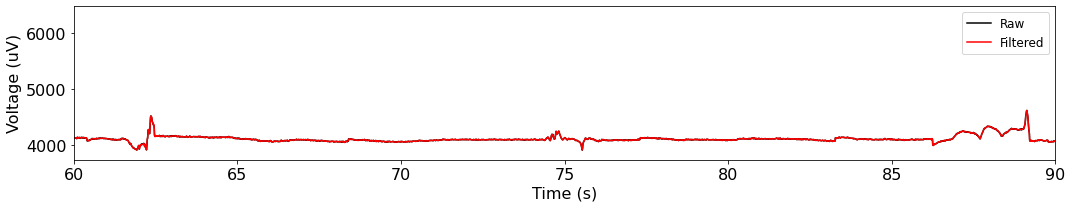

In [23]:
# Plot filtered signal
plot_time_series(times, [sig_filt1, sig_filt2], ['Raw', 'Filtered'], xlim=[60,90]) # , xlim=[30,50]

# ???

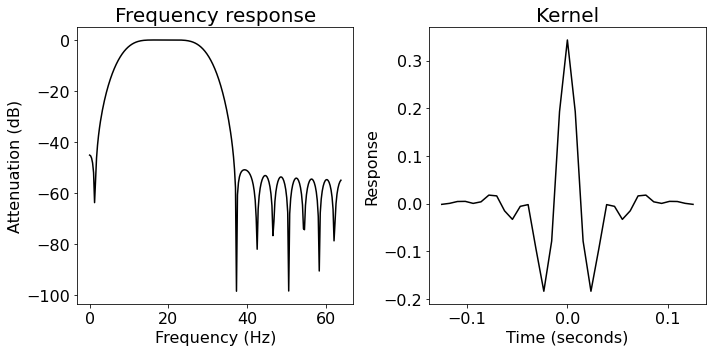

In [24]:
f_range3 = (8, 30)
sig_filt3, kernel = filter_signal(sig_filt2, fs, 'bandpass', f_range3, n_cycles=2,
                                 plot_properties=True, return_filter=True)

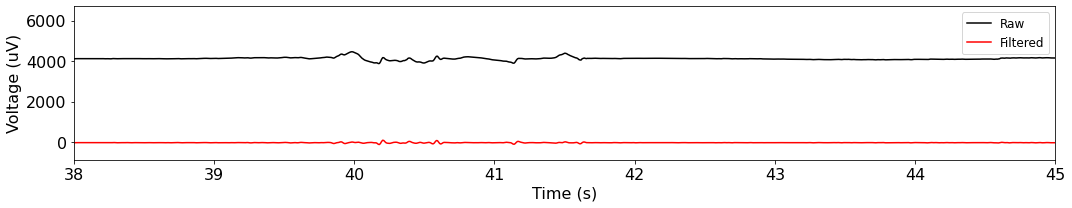

In [31]:
# Plot filtered signal
plot_time_series(times, [sig_filt2, sig_filt3], ['Raw', 'Filtered'], xlim=[38,45]) # , xlim=[30,50]